# cross-validation for a polynomial regression problem

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)

In [3]:
def generate_syn_data_non_linear(n: int):
    a, b = -5.0, 5.0
    step = (b-a)/n
    x = np.arange(a, b, step)
    
    eps = np.random.normal(size=n, scale=8.0)
    
    coeff = np.array([10, 2, -2, 1])
    poly = np.array([coeff[i]*x**i for i in range(len(coeff))]).sum(axis=0)
    y = poly + eps
        
    return x.reshape(-1,1), y

In [4]:
X, y = generate_syn_data_non_linear(n=250)

Text(0, 0.5, '$y$')

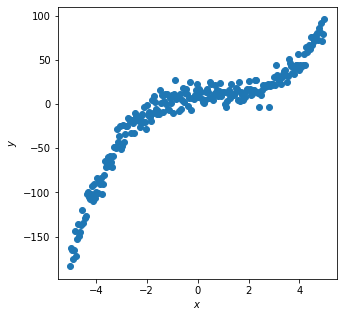

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(X[:,0], y, 'o')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

# Simple Pipeline

## Build a polynomial (non-linear) regressor
For a training set $\mathcal{D}:=\{(x_i,y_i)\}$, we look for a function of degree $k$, which we denote by $f^*(x; \mathcal{D}, k)$, such that
$$
f^{*}_{k} := \arg\min_{f \in \mathcal{F}_k} \sum_{i=1}^{n} \lVert f(x_i) - y_i \rVert_2^{2},
$$
where $ k \in \mathbb{N}^{+}$,
$$
\mathcal{F}_k := \big\{f : f(x) = \sum_{\ell=0}^{k} a_\ell x^{\ell} \big\}.
$$
In our setting $k$ is a hyper-parameter to be determined.

## Cross-validation (determining $k$)
Let us partition the dataset into $K$ non-overlapping one:
$$
\mathcal{D} = \cup_{j=1}^{K} \mathcal{D}_j, \quad \mathcal{D}_j \cap \mathcal{D}_{j'} = \emptyset, \forall j\not=j'.
$$
In a $K$-folde cross-validation we fit the function on $K-1$-folds and compute its error on the remaining fold for a given polynomial degree $k$. That is we fit using $\mathcal{D} \setminus \mathcal{D}_j$ and measure the error on $\mathcal{D}_j$ for $j=1,\dots,K$. Let us denote the avergae error on the test sets for a given polynomial degree by $e(k)$. We can compute $e(k)$ by
$$
e(k) := \frac{1}{K} \sum_{j=1}^{K} \sum_{(x, y) \in \mathcal{D}_j} 
\lVert f^*(x; \mathcal{D}\setminus \mathcal{D}_j, k) - y \rVert_2^2.
$$
Then the optimal polynomial degree $k$ is computed by finding the minimum error on the test set, i.e.,
$$
k^* := \arg\min_{j=1,\dots, K} e(k)
$$

In [6]:
def get_simple_pipeline(estimator: str, scoring: str, 
                        n_folds: int = 10, n_jobs: int = 2, 
                        random_state = None, verbose: bool = True):

    cv = KFold(n_splits=n_folds, shuffle=False, random_state=None)
    
    if estimator == 'linear_regression':
        est = LinearRegression(n_jobs=n_jobs)
        est_param_grid = {'fit_intercept': [True, False]}
    elif estimator == 'ridge':
        est = Ridge()
        est_param_grid = {'alpha': np.arange(0.1, 10.0, 1.0), 
                          'fit_intercept': [True, False]}        
    else:
        raise ValueError('undefined estimator')
    
    
    core_pipe = Pipeline(steps=[
        ('poly_features', PolynomialFeatures()),
        ('estimator', est)
    ], verbose=verbose)
    
    est_params = {
        '__'.join(['estimator', key]): val for (key, val) in est_param_grid.items()
    }
    param_grid = {
        'poly_features__degree': [1, 2, 3, 6, 10, 20]
    }
    param_grid.update(est_params)
    
    
    grid_search = GridSearchCV(estimator=core_pipe, scoring=scoring, 
                               param_grid=param_grid, n_jobs=n_jobs, refit=True, cv=cv, verbose=verbose)
    
    steps = [('grid_search', grid_search)]
    
    return Pipeline(steps=steps, verbose=verbose)

# Settings

In [7]:
RANDOM_STATE = 102

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Run simple pipeline with linear regression as estimator

In [9]:
pipe = get_simple_pipeline(estimator='linear_regression', 
                           scoring='neg_mean_squared_error', 
                           random_state=RANDOM_STATE)

In [10]:
pipe.steps[0][1]

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('estimator',
                                        LinearRegression(n_jobs=2))],
                                verbose=True),
             n_jobs=2,
             param_grid={'estimator__fit_intercept': [True, False],
                         'poly_features__degree': [1, 2, 3, 6, 10, 20]},
             scoring='neg_mean_squared_error', verbose=True)

In [11]:
pipe.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.0s
[Pipeline] ....... (step 1 of 1) Processing grid_search, total=   1.0s


Pipeline(steps=[('grid_search',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                              estimator=Pipeline(steps=[('poly_features',
                                                         PolynomialFeatures()),
                                                        ('estimator',
                                                         LinearRegression(n_jobs=2))],
                                                 verbose=True),
                              n_jobs=2,
                              param_grid={'estimator__fit_intercept': [True,
                                                                       False],
                                          'poly_features__degree': [1, 2, 3, 6,
                                                                    10, 20]},
                              scoring='neg_mean_squared_error',
                              verbose=True))],
         verbose=True)

# Best estimator should have polynomial degree 3

In [12]:
pipe.steps[0][1].best_params_

{'estimator__fit_intercept': False, 'poly_features__degree': 3}

In [13]:
pipe.steps[0][1].cv_results_

{'mean_fit_time': array([0.00167542, 0.00175986, 0.00150247, 0.00137963, 0.00125034,
        0.00163143, 0.00145156, 0.00090725, 0.00126183, 0.00113299,
        0.00108736, 0.00166709]),
 'std_fit_time': array([0.00039381, 0.00065719, 0.00076996, 0.00014759, 0.00027199,
        0.00051005, 0.0003466 , 0.00016164, 0.00026783, 0.0003126 ,
        0.00020949, 0.00032648]),
 'mean_score_time': array([0.00067284, 0.00078695, 0.00051832, 0.00066564, 0.00052722,
        0.00066783, 0.00060015, 0.00041974, 0.00054681, 0.00049946,
        0.00045233, 0.00070295]),
 'std_score_time': array([1.68035698e-04, 3.11630723e-04, 4.95865939e-05, 1.84538643e-04,
        1.72359882e-04, 1.91984478e-04, 1.30287706e-04, 7.92213852e-05,
        1.27631736e-04, 1.34078666e-04, 3.84637672e-05, 1.72897669e-04]),
 'param_estimator__fit_intercept': masked_array(data=[True, True, True, True, True, True, False, False,
                    False, False, False, False],
              mask=[False, False, False, False, F

In [14]:
y_pred = pipe.steps[0][1].best_estimator_.predict(X_test)

Text(0.5, 0, '$x_0$')

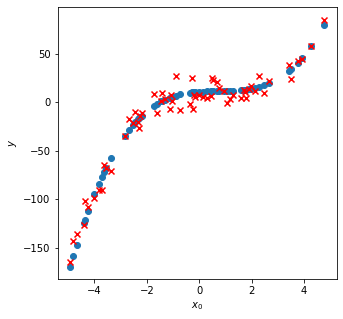

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_test[:,0], y_pred, label='prediction', marker='o')
ax.scatter(X_test[:,0], y_test, label='truth', marker='x', color='red')
ax.set_ylabel('$y$')
ax.set_xlabel('$x_0$')

# Run simple pipeline with Ridge as estimator (it has regularization)

In [16]:
pipe = get_simple_pipeline(estimator='ridge', 
                           scoring='neg_mean_squared_error', 
                           random_state=RANDOM_STATE)

In [17]:
pipe.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[Pipeline] ..... (step 1 of 2) Processing poly_features, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing estimator, total=   0.0s
[Pipeline] ....... (step 1 of 1) Processing grid_search, total=   1.7s


Pipeline(steps=[('grid_search',
                 GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                              estimator=Pipeline(steps=[('poly_features',
                                                         PolynomialFeatures()),
                                                        ('estimator', Ridge())],
                                                 verbose=True),
                              n_jobs=2,
                              param_grid={'estimator__alpha': array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]),
                                          'estimator__fit_intercept': [True,
                                                                       False],
                                          'poly_features__degree': [1, 2, 3, 6,
                                                                    10, 20]},
                              scoring='neg_mean_squared_error',
                              verbose=True)

In [18]:
pipe.steps[0][1].best_estimator_

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('estimator', Ridge(alpha=1.1, fit_intercept=False))],
         verbose=True)

In [19]:
y_pred = pipe.steps[0][1].best_estimator_.predict(X_test)

Text(0.5, 0, '$x_0$')

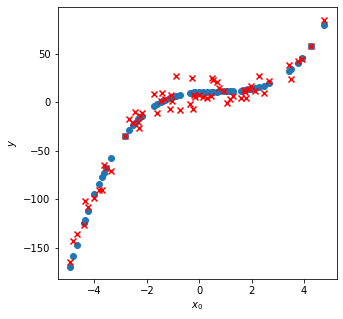

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_test[:,0], y_pred, label='prediction', marker='o')
ax.scatter(X_test[:,0], y_test, label='truth', marker='x', color='red')
ax.set_ylabel('$y$')
ax.set_xlabel('$x_0$')